# Flight Status Predictions
## Group Memembers :
### Nicolas Casadevall, Pranav Ramesh Deshpande, Kriti Sharma

In [71]:
#base modules
import os
import sys
import copy
import logging
from collections import OrderedDict

#for manipulating data
import pandas as pd
import numpy as np
import math
import dill 

# for Machine Learning
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.inspection import permutation_importance
from scipy.cluster import hierarchy
import catboost
from catboost import CatBoostClassifier, CatBoostRegressor, Pool, cv

# For visualization
from IPython.display import display
from matplotlib import pyplot as plt

In [2]:
# Finding the path
path_to_repo = os.path.dirname(os.getcwd())
path_to_repo

'C:\\Users\\prana\\Coding\\Advanced Machine Learning'

In [3]:
# Import the Utils
sys.path.insert(0, os.path.join(path_to_repo, 'src'))
from emlyon.utils import *

In [4]:
import importlib
from sklearn.linear_model import LinearRegression

In [5]:
os.getcwd()

'C:\\Users\\prana\\Coding\\Advanced Machine Learning\\Project Files'

In [118]:
#DATA_PATH = r'/Users/nicolascasadevall/Downloads'

In [119]:
#os.chdir(DATA_PATH)

In [6]:
df = pd.read_csv('Combined_Flights_2021.csv')

## Project Introduction

The Data set we have picked for the project is Flight Status Details. The data set primarily provides the logs of Flights in the USA for the year 2021. The data is a rich collection of both numerical and categorical data types, which presents an interesting problem set to pick regression and classification models.

To begin with the data set provides basic data from flight dates, status such as cancelled, diverted, departure times, air times, various time logs such as wheels on/off, taxi on/off, air time, airline information, airport Computer reservation system data

Our Initial approach involved inspecting the data, which immediate presented the idea of looking at if flights are cancelled, diverted or delayed. While classification presented an interesting problem, making mere delay categories would be straightforward from massive data. We instead took a look at the Column ArrDelayMinutes, which provided the arrival time delay in minutes. This would make for a great regression problem given the idealogy of the prediction

Since the Flight Date in a way provides the pointer for weather influence on cancellations and diversions and various other factors can be deduced from the data set. This approach gave us the opportunity to logically reason out our exploration and model performances. And in a strategic way eliminating more direct cause columns to make a challenge in building more effective model with lesser information or rather historical and trend based information.

The flight information is about 6 Million Rows which is more what our computers can handle for experimentation. We have hence limited our data set to operations of American Airlines. This allows us to work with about 736k rows and 61 columns

## DataFrame

In [7]:
df

,FlightDate,Airline,Origin,Dest,Cancelled,Diverted,CRSDepTime,DepTime,DepDelayMinutes,DepDelay,...,WheelsOff,WheelsOn,TaxiIn,CRSArrTime,ArrDelay,ArrDel15,ArrivalDelayGroups,ArrTimeBlk,DistanceGroup,DivAirportLandings
0,2021-03-03,SkyWest Airlines Inc.,SGU,PHX,False,False,724,714.0,0.0,-10.0,...,724.0,813.0,5.0,843,-25.0,0.0,-2.0,0800-0859,2,0.0
1,2021-03-03,SkyWest Airlines Inc.,PHX,SGU,False,False,922,917.0,0.0,-5.0,...,940.0,1028.0,3.0,1040,-9.0,0.0,-1.0,1000-1059,2,0.0
2,2021-03-03,SkyWest Airlines Inc.,MHT,ORD,False,False,1330,1321.0,0.0,-9.0,...,1336.0,1445.0,16.0,1530,-29.0,0.0,-2.0,1500-1559,4,0.0
3,2021-03-03,SkyWest Airlines Inc.,DFW,TRI,False,False,1645,1636.0,0.0,-9.0,...,1703.0,1955.0,7.0,2010,-8.0,0.0,-1.0,2000-2059,4,0.0
4,2021-03-03,SkyWest Airlines Inc.,PHX,BFL,False,False,1844,1838.0,0.0,-6.0,...,1851.0,1900.0,3.0,1925,-22.0,0.0,-2.0,1900-1959,2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6311866,2021-06-01,Southwest Airlines Co.,BNA,MDW,False,False,1255,1301.0,6.0,6.0,...,1310.0,1416.0,5.0,1430,-9.0,0.0,-1.0,1400-1459,2,0.0
6311867,2021-06-01,Southwest Airlines Co.,BNA,MDW,False,False,730,727.0,0.0,-3.0,...,740.0,842.0,3.0,900,-15.0,0.0,-1.0,0900-0959,2,0.0
6311868,2021-06-01,Southwest Airlines Co.,BNA,MIA,False,False,800,757.0,0.0,-3.0,...,811.0,1056.0,5.0,1110,-9.0,0.0,-1.0,1100-1159,4,0.0
6311869,2021-06-01,Southwest Airlines Co.,BNA,MIA,False,False,1300,1252.0,0.0,-8.0,...,1300.0,1554.0,5.0,1620,-21.0,0.0,-2.0,1600-1659,4,0.0


# Data Exploration

In [8]:
#displaying the columns
df.columns

Index(['FlightDate', 'Airline', 'Origin', 'Dest', 'Cancelled', 'Diverted',
       'CRSDepTime', 'DepTime', 'DepDelayMinutes', 'DepDelay', 'ArrTime',
       'ArrDelayMinutes', 'AirTime', 'CRSElapsedTime', 'ActualElapsedTime',
       'Distance', 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek',
       'Marketing_Airline_Network', 'Operated_or_Branded_Code_Share_Partners',
       'DOT_ID_Marketing_Airline', 'IATA_Code_Marketing_Airline',
       'Flight_Number_Marketing_Airline', 'Operating_Airline',
       'DOT_ID_Operating_Airline', 'IATA_Code_Operating_Airline',
       'Tail_Number', 'Flight_Number_Operating_Airline', 'OriginAirportID',
       'OriginAirportSeqID', 'OriginCityMarketID', 'OriginCityName',
       'OriginState', 'OriginStateFips', 'OriginStateName', 'OriginWac',
       'DestAirportID', 'DestAirportSeqID', 'DestCityMarketID', 'DestCityName',
       'DestState', 'DestStateFips', 'DestStateName', 'DestWac', 'DepDel15',
       'DepartureDelayGroups', 'DepTimeBlk', 'TaxiOu

In [9]:
#displaying column in list
df.columns.to_list()

['FlightDate',
 'Airline',
 'Origin',
 'Dest',
 'Cancelled',
 'Diverted',
 'CRSDepTime',
 'DepTime',
 'DepDelayMinutes',
 'DepDelay',
 'ArrTime',
 'ArrDelayMinutes',
 'AirTime',
 'CRSElapsedTime',
 'ActualElapsedTime',
 'Distance',
 'Year',
 'Quarter',
 'Month',
 'DayofMonth',
 'DayOfWeek',
 'Marketing_Airline_Network',
 'Operated_or_Branded_Code_Share_Partners',
 'DOT_ID_Marketing_Airline',
 'IATA_Code_Marketing_Airline',
 'Flight_Number_Marketing_Airline',
 'Operating_Airline',
 'DOT_ID_Operating_Airline',
 'IATA_Code_Operating_Airline',
 'Tail_Number',
 'Flight_Number_Operating_Airline',
 'OriginAirportID',
 'OriginAirportSeqID',
 'OriginCityMarketID',
 'OriginCityName',
 'OriginState',
 'OriginStateFips',
 'OriginStateName',
 'OriginWac',
 'DestAirportID',
 'DestAirportSeqID',
 'DestCityMarketID',
 'DestCityName',
 'DestState',
 'DestStateFips',
 'DestStateName',
 'DestWac',
 'DepDel15',
 'DepartureDelayGroups',
 'DepTimeBlk',
 'TaxiOut',
 'WheelsOff',
 'WheelsOn',
 'TaxiIn',
 'CRS

In [10]:
#size check
df.shape

(6311871, 61)

In [11]:
#Displaying intiger location based indexing by position with scalar integer
df.iloc[100000]

FlightDate                                          2021-03-08
Airline               GoJet Airlines, LLC d/b/a United Express
Origin                                                     ORD
Dest                                                       PIT
Cancelled                                                False
                                        ...                   
ArrDel15                                                   0.0
ArrivalDelayGroups                                        -1.0
ArrTimeBlk                                           1300-1359
DistanceGroup                                                2
DivAirportLandings                                         0.0
Name: 100000, Length: 61, dtype: object

In [12]:
#numerical description of data in DataFrame
df.describe()

,CRSDepTime,DepTime,DepDelayMinutes,DepDelay,ArrTime,ArrDelayMinutes,AirTime,CRSElapsedTime,ActualElapsedTime,Distance,...,TaxiOut,WheelsOff,WheelsOn,TaxiIn,CRSArrTime,ArrDelay,ArrDel15,ArrivalDelayGroups,DistanceGroup,DivAirportLandings
count,6.311871e+06,6.203546e+06,6.203458e+06,6.203458e+06,6.199463e+06,6.185870e+06,6.185870e+06,6.311870e+06,6.185870e+06,6.311871e+06,...,6.201518e+06,6.201518e+06,6.199446e+06,6.199446e+06,6.311871e+06,6.185870e+06,6.185870e+06,6.185870e+06,6.311871e+06,6.311869e+06
mean,1.323953e+03,1.326878e+03,1.276132e+01,9.468347e+00,1.476758e+03,1.252928e+01,1.105702e+02,1.405049e+02,1.344372e+02,7.955762e+02,...,1.619500e+01,1.349829e+03,1.471500e+03,7.683753e+00,1.498272e+03,3.290244e+00,1.726611e-01,-3.158285e-01,3.653994e+00,3.338472e-03
std,4.741972e+02,4.868330e+02,4.736319e+01,4.837844e+01,5.137709e+02,4.674770e+01,6.888632e+01,7.031368e+01,7.023792e+01,5.832931e+02,...,8.584121e+00,4.879919e+02,5.096815e+02,6.375447e+00,4.946565e+02,5.012311e+01,3.779540e-01,2.266604e+00,2.281563e+00,1.046246e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,-1.050000e+02,1.000000e+00,0.000000e+00,8.000000e+00,-2.920000e+02,1.400000e+01,3.100000e+01,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-1.070000e+02,0.000000e+00,-2.000000e+00,1.000000e+00,0.000000e+00
25%,9.200000e+02,9.230000e+02,0.000000e+00,-6.000000e+00,1.105000e+03,0.000000e+00,6.000000e+01,9.000000e+01,8.300000e+01,3.700000e+02,...,1.100000e+01,9.380000e+02,1.101000e+03,4.000000e+00,1.118000e+03,-1.600000e+01,0.000000e+00,-2.000000e+00,2.000000e+00,0.000000e+00
50%,1.315000e+03,1.321000e+03,0.000000e+00,-2.000000e+00,1.509000e+03,0.000000e+00,9.400000e+01,1.240000e+02,1.180000e+02,6.460000e+02,...,1.400000e+01,1.334000e+03,1.505000e+03,6.000000e+00,1.520000e+03,-7.000000e+00,0.000000e+00,-1.000000e+00,3.000000e+00,0.000000e+00
75%,1.723000e+03,1.729000e+03,6.000000e+00,6.000000e+00,1.909000e+03,6.000000e+00,1.400000e+02,1.700000e+02,1.650000e+02,1.033000e+03,...,1.900000e+01,1.743000e+03,1.904000e+03,9.000000e+00,1.914000e+03,6.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,0.000000e+00
max,2.359000e+03,2.400000e+03,3.095000e+03,3.095000e+03,2.400000e+03,3.089000e+03,7.110000e+02,1.312000e+03,7.940000e+02,5.812000e+03,...,2.560000e+02,2.400000e+03,2.400000e+03,2.510000e+02,2.400000e+03,3.089000e+03,1.000000e+00,1.200000e+01,1.100000e+01,9.000000e+00


In [15]:
#Info such as type - about dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6311871 entries, 0 to 6311870
Data columns (total 61 columns):
 #   Column                                   Dtype  
---  ------                                   -----  
 0   FlightDate                               object 
 1   Airline                                  object 
 2   Origin                                   object 
 3   Dest                                     object 
 4   Cancelled                                bool   
 5   Diverted                                 bool   
 6   CRSDepTime                               int64  
 7   DepTime                                  float64
 8   DepDelayMinutes                          float64
 9   DepDelay                                 float64
 10  ArrTime                                  float64
 11  ArrDelayMinutes                          float64
 12  AirTime                                  float64
 13  CRSElapsedTime                           float64
 14  ActualElapsedTime 

In [13]:
# Display all the data to be able to transpose later. Max columns/rows = 1000
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [14]:
#Transposing Rows and Columns
display_all(df.head().T)

,0,1,2,3,4
FlightDate,2021-03-03,2021-03-03,2021-03-03,2021-03-03,2021-03-03
Airline,SkyWest Airlines Inc.,SkyWest Airlines Inc.,SkyWest Airlines Inc.,SkyWest Airlines Inc.,SkyWest Airlines Inc.
Origin,SGU,PHX,MHT,DFW,PHX
Dest,PHX,SGU,ORD,TRI,BFL
Cancelled,False,False,False,False,False
Diverted,False,False,False,False,False
CRSDepTime,724,922,1330,1645,1844
DepTime,714.0,917.0,1321.0,1636.0,1838.0
DepDelayMinutes,0.0,0.0,0.0,0.0,0.0
DepDelay,-10.0,-5.0,-9.0,-9.0,-6.0


In [15]:
# Looking at the flights cancelled
df[df["Cancelled"] == "True"]

,FlightDate,Airline,Origin,Dest,Cancelled,Diverted,CRSDepTime,DepTime,DepDelayMinutes,DepDelay,...,WheelsOff,WheelsOn,TaxiIn,CRSArrTime,ArrDelay,ArrDel15,ArrivalDelayGroups,ArrTimeBlk,DistanceGroup,DivAirportLandings


In [16]:
# Looking at the flights diverted
df[df["Diverted"] == "True"]

,FlightDate,Airline,Origin,Dest,Cancelled,Diverted,CRSDepTime,DepTime,DepDelayMinutes,DepDelay,...,WheelsOff,WheelsOn,TaxiIn,CRSArrTime,ArrDelay,ArrDel15,ArrivalDelayGroups,ArrTimeBlk,DistanceGroup,DivAirportLandings


> Explore columns printing every roughly 10 columns

In [20]:
df[['FlightDate', 'Airline', 'Origin', 'Dest', 'Cancelled', 'Diverted',
       'CRSDepTime', 'DepTime', 'DepDelayMinutes', 'DepDelay', 'ArrTime']]

,FlightDate,Airline,Origin,Dest,Cancelled,Diverted,CRSDepTime,DepTime,DepDelayMinutes,DepDelay,ArrTime
0,2021-03-03,SkyWest Airlines Inc.,SGU,PHX,False,False,724,714.0,0.0,-10.0,818.0
1,2021-03-03,SkyWest Airlines Inc.,PHX,SGU,False,False,922,917.0,0.0,-5.0,1031.0
2,2021-03-03,SkyWest Airlines Inc.,MHT,ORD,False,False,1330,1321.0,0.0,-9.0,1501.0
3,2021-03-03,SkyWest Airlines Inc.,DFW,TRI,False,False,1645,1636.0,0.0,-9.0,2002.0
4,2021-03-03,SkyWest Airlines Inc.,PHX,BFL,False,False,1844,1838.0,0.0,-6.0,1903.0
...,...,...,...,...,...,...,...,...,...,...,...
6311866,2021-06-01,Southwest Airlines Co.,BNA,MDW,False,False,1255,1301.0,6.0,6.0,1421.0
6311867,2021-06-01,Southwest Airlines Co.,BNA,MDW,False,False,730,727.0,0.0,-3.0,845.0
6311868,2021-06-01,Southwest Airlines Co.,BNA,MIA,False,False,800,757.0,0.0,-3.0,1101.0
6311869,2021-06-01,Southwest Airlines Co.,BNA,MIA,False,False,1300,1252.0,0.0,-8.0,1559.0


In [21]:
#Checking the data type and format of the date columns
df[['ArrDelayMinutes', 'AirTime', 'CRSElapsedTime', 'ActualElapsedTime',
       'Distance', 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek']]

,ArrDelayMinutes,AirTime,CRSElapsedTime,ActualElapsedTime,Distance,Year,Quarter,Month,DayofMonth,DayOfWeek
0,0.0,49.0,79.0,64.0,262.0,2021,1,3,3,3
1,0.0,48.0,78.0,74.0,262.0,2021,1,3,3,3
2,0.0,129.0,180.0,160.0,843.0,2021,1,3,3,3
3,0.0,112.0,145.0,146.0,868.0,2021,1,3,3,3
4,0.0,69.0,101.0,85.0,425.0,2021,1,3,3,3
...,...,...,...,...,...,...,...,...,...,...
6311866,0.0,66.0,95.0,80.0,395.0,2021,2,6,1,2
6311867,0.0,62.0,90.0,78.0,395.0,2021,2,6,1,2
6311868,0.0,105.0,130.0,124.0,806.0,2021,2,6,1,2
6311869,0.0,114.0,140.0,127.0,806.0,2021,2,6,1,2


In [22]:
df[['Marketing_Airline_Network', 'Operated_or_Branded_Code_Share_Partners',
       'DOT_ID_Marketing_Airline', 'IATA_Code_Marketing_Airline',
       'Flight_Number_Marketing_Airline', 'Operating_Airline',
       'DOT_ID_Operating_Airline', 'IATA_Code_Operating_Airline',
       'Tail_Number', 'Flight_Number_Operating_Airline']]

,Marketing_Airline_Network,Operated_or_Branded_Code_Share_Partners,DOT_ID_Marketing_Airline,IATA_Code_Marketing_Airline,Flight_Number_Marketing_Airline,Operating_Airline,DOT_ID_Operating_Airline,IATA_Code_Operating_Airline,Tail_Number,Flight_Number_Operating_Airline
0,AA,AA_CODESHARE,19805,AA,3133,OO,20304,OO,N728SK,3133
1,AA,AA_CODESHARE,19805,AA,3134,OO,20304,OO,N752SK,3134
2,AA,AA_CODESHARE,19805,AA,3135,OO,20304,OO,N766SK,3135
3,AA,AA_CODESHARE,19805,AA,3136,OO,20304,OO,N752EV,3136
4,AA,AA_CODESHARE,19805,AA,3137,OO,20304,OO,N715SK,3137
...,...,...,...,...,...,...,...,...,...,...
6311866,WN,WN,19393,WN,1740,WN,19393,WN,N8695D,1740
6311867,WN,WN,19393,WN,2197,WN,19393,WN,N7863A,2197
6311868,WN,WN,19393,WN,443,WN,19393,WN,N7867A,443
6311869,WN,WN,19393,WN,2991,WN,19393,WN,N7827A,2991


In [23]:
df[['OriginAirportID','OriginAirportSeqID', 'OriginCityMarketID', 'OriginCityName',
       'OriginState', 'OriginStateFips', 'OriginStateName', 'OriginWac']]

,OriginAirportID,OriginAirportSeqID,OriginCityMarketID,OriginCityName,OriginState,OriginStateFips,OriginStateName,OriginWac
0,14794,1479405,34794,"St. George, UT",UT,49,Utah,87
1,14107,1410702,30466,"Phoenix, AZ",AZ,4,Arizona,81
2,13296,1329604,30721,"Manchester, NH",NH,33,New Hampshire,14
3,11298,1129806,30194,"Dallas/Fort Worth, TX",TX,48,Texas,74
4,14107,1410702,30466,"Phoenix, AZ",AZ,4,Arizona,81
...,...,...,...,...,...,...,...,...
6311866,10693,1069302,30693,"Nashville, TN",TN,47,Tennessee,54
6311867,10693,1069302,30693,"Nashville, TN",TN,47,Tennessee,54
6311868,10693,1069302,30693,"Nashville, TN",TN,47,Tennessee,54
6311869,10693,1069302,30693,"Nashville, TN",TN,47,Tennessee,54


In [24]:
df[['DestAirportID', 'DestAirportSeqID', 'DestCityMarketID', 'DestCityName',
       'DestState', 'DestStateFips', 'DestStateName', 'DestWac', 'DepDel15',
       'DepartureDelayGroups']]

,DestAirportID,DestAirportSeqID,DestCityMarketID,DestCityName,DestState,DestStateFips,DestStateName,DestWac,DepDel15,DepartureDelayGroups
0,14107,1410702,30466,"Phoenix, AZ",AZ,4,Arizona,81,0.0,-1.0
1,14794,1479405,34794,"St. George, UT",UT,49,Utah,87,0.0,-1.0
2,13930,1393007,30977,"Chicago, IL",IL,17,Illinois,41,0.0,-1.0
3,15323,1532305,35323,"Bristol/Johnson City/Kingsport, TN",TN,47,Tennessee,54,0.0,-1.0
4,10561,1056103,30561,"Bakersfield, CA",CA,6,California,91,0.0,-1.0
...,...,...,...,...,...,...,...,...,...,...
6311866,13232,1323202,30977,"Chicago, IL",IL,17,Illinois,41,0.0,0.0
6311867,13232,1323202,30977,"Chicago, IL",IL,17,Illinois,41,0.0,-1.0
6311868,13303,1330303,32467,"Miami, FL",FL,12,Florida,33,0.0,-1.0
6311869,13303,1330303,32467,"Miami, FL",FL,12,Florida,33,0.0,-1.0


In [25]:
df[['DepTimeBlk', 'TaxiOut', 'WheelsOff',
       'WheelsOn', 'TaxiIn', 'CRSArrTime', 'ArrDelay', 'ArrDel15',
       'ArrivalDelayGroups', 'ArrTimeBlk', 'DistanceGroup',
       'DivAirportLandings']]

,DepTimeBlk,TaxiOut,WheelsOff,WheelsOn,TaxiIn,CRSArrTime,ArrDelay,ArrDel15,ArrivalDelayGroups,ArrTimeBlk,DistanceGroup,DivAirportLandings
0,0700-0759,10.0,724.0,813.0,5.0,843,-25.0,0.0,-2.0,0800-0859,2,0.0
1,0900-0959,23.0,940.0,1028.0,3.0,1040,-9.0,0.0,-1.0,1000-1059,2,0.0
2,1300-1359,15.0,1336.0,1445.0,16.0,1530,-29.0,0.0,-2.0,1500-1559,4,0.0
3,1600-1659,27.0,1703.0,1955.0,7.0,2010,-8.0,0.0,-1.0,2000-2059,4,0.0
4,1800-1859,13.0,1851.0,1900.0,3.0,1925,-22.0,0.0,-2.0,1900-1959,2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6311866,1200-1259,9.0,1310.0,1416.0,5.0,1430,-9.0,0.0,-1.0,1400-1459,2,0.0
6311867,0700-0759,13.0,740.0,842.0,3.0,900,-15.0,0.0,-1.0,0900-0959,2,0.0
6311868,0800-0859,14.0,811.0,1056.0,5.0,1110,-9.0,0.0,-1.0,1100-1159,4,0.0
6311869,1300-1359,8.0,1300.0,1554.0,5.0,1620,-21.0,0.0,-2.0,1600-1659,4,0.0


In [124]:
df["DivAirportLandings"].value_counts()

0.0    6296222
1.0      14877
9.0        665
2.0        105
Name: DivAirportLandings, dtype: int64

In [125]:
df['Airline'].value_counts()

Southwest Airlines Co.                       1064640
SkyWest Airlines Inc.                         753343
Delta Air Lines Inc.                          747998
American Airlines Inc.                        736399
United Air Lines Inc.                         446837
Republic Airlines                             332926
Endeavor Air Inc.                             266867
Envoy Air                                     255751
Comair Inc.                                   222602
JetBlue Airways                               202702
Spirit Air Lines                              191361
Alaska Airlines Inc.                          188955
Mesa Airlines Inc.                            159789
Frontier Airlines Inc.                        137142
Allegiant Air                                 115881
Horizon Air                                   111628
Capital Cargo International                    99331
Air Wisconsin Airlines Corp                    80256
Commutair Aka Champlain Enterprises, Inc.     

### Column & Feature Engineering - Removal of Irrelevant Columns
Considering that there are 61 columns, it is logical to retain the logical and relevant columns. From our data exploration we find that the below columns have nothing to offer for the model:
Cancelled/Diverted: none of the Flights are Cancelled or Diverted. Hence they provide just constant non usable information
Year: once again since this is data for 2021, it is a constant
Origin & Destination Related Columns: There are several columns which are related to the flight origin such as state, sequence ID etc. which all point towards the same information and end up becoming corellated producing no new information. 
Airline Related Columns: Since we are using the data of a single airlines, these columns provide the same constant info.
Delay Group Columns

### Column & Feature Engineering - Removal of Extremely Driving Columns
Certain columns such as DepartureDelayGrps and ArrivalDelayGroups directly provide information of delay to the model, this makes the prediction rather direct by providing a classification answer for our target column. These are hence being dropped.

In [17]:
#dropping columns not needed
df.drop("Cancelled", inplace = True, axis=1)
df.drop("Diverted", inplace = True, axis=1)
df.drop("Year", inplace = True, axis=1)
df.drop("OriginStateFips", inplace = True, axis=1)
df.drop("OriginState", inplace = True, axis=1)
df.drop("OriginAirportSeqID", inplace = True, axis=1)
df.drop("OriginCityMarketID", inplace = True, axis=1)
df.drop("OriginWac", inplace = True, axis =1)
df.drop("DestStateFips", inplace = True, axis=1)
df.drop("DestAirportSeqID", inplace = True, axis=1)
df.drop("DestCityMarketID", inplace = True, axis=1)
df.drop("DestState", inplace = True, axis=1)
df.drop("DestWac", inplace = True, axis =1)
df.drop("Operated_or_Branded_Code_Share_Partners", inplace=True, axis = 1)
df.drop("DOT_ID_Marketing_Airline", inplace = True, axis=1)
df.drop("DOT_ID_Operating_Airline", inplace = True, axis=1)
df.drop("IATA_Code_Operating_Airline", inplace = True, axis=1)
df.drop("DepTimeBlk", inplace = True, axis=1)
df.drop("DivAirportLandings", inplace = True, axis=1)
df.drop("ArrDel15", inplace = True, axis=1)
df.drop("DistanceGroup", inplace = True, axis=1)
df.drop("DepDel15", inplace = True, axis=1)
df.drop("DepartureDelayGroups", inplace = True, axis=1)
df.drop("ArrivalDelayGroups", inplace = True, axis=1)
df.drop("Marketing_Airline_Network", inplace = True, axis = 1)
df.drop("IATA_Code_Marketing_Airline", inplace=True, axis = 1)

In [20]:
#Subset the DataFrame for Airline "American Airlines Inc."
df_AA = df[df['Airline']=='American Airlines Inc.']

### Further Exploration and Preprocessing Data

In [21]:
df_AA

,FlightDate,Airline,Origin,Dest,CRSDepTime,DepTime,DepDelayMinutes,DepDelay,ArrTime,ArrDelayMinutes,...,DestAirportID,DestCityName,DestStateName,TaxiOut,WheelsOff,WheelsOn,TaxiIn,CRSArrTime,ArrDelay,ArrTimeBlk
364382,2021-03-01,American Airlines Inc.,JFK,LAX,900,900.0,0.0,0.0,1147.0,0.0,...,12892,"Los Angeles, CA",California,15.0,915.0,1143.0,4.0,1225,-38.0,1200-1259
364383,2021-03-02,American Airlines Inc.,JFK,LAX,900,858.0,0.0,-2.0,1206.0,0.0,...,12892,"Los Angeles, CA",California,23.0,921.0,1139.0,27.0,1225,-19.0,1200-1259
364384,2021-03-03,American Airlines Inc.,JFK,LAX,900,907.0,7.0,7.0,1222.0,0.0,...,12892,"Los Angeles, CA",California,11.0,918.0,1217.0,5.0,1225,-3.0,1200-1259
364385,2021-03-04,American Airlines Inc.,JFK,LAX,900,859.0,0.0,-1.0,1201.0,0.0,...,12892,"Los Angeles, CA",California,22.0,921.0,1152.0,9.0,1208,-7.0,1200-1259
364386,2021-03-05,American Airlines Inc.,JFK,LAX,900,917.0,17.0,17.0,1200.0,0.0,...,12892,"Los Angeles, CA",California,18.0,935.0,1152.0,8.0,1208,-8.0,1200-1259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6120544,2021-06-08,American Airlines Inc.,DFW,PNS,1246,1313.0,27.0,27.0,1458.0,21.0,...,14193,"Pensacola, FL",Florida,11.0,1324.0,1453.0,5.0,1437,21.0,1400-1459
6120545,2021-06-09,American Airlines Inc.,DFW,PNS,1246,1303.0,17.0,17.0,1446.0,9.0,...,14193,"Pensacola, FL",Florida,12.0,1315.0,1442.0,4.0,1437,9.0,1400-1459
6120546,2021-06-10,American Airlines Inc.,DFW,PNS,1246,1246.0,0.0,0.0,1438.0,1.0,...,14193,"Pensacola, FL",Florida,18.0,1304.0,1428.0,10.0,1437,1.0,1400-1459
6120547,2021-06-11,American Airlines Inc.,DFW,PNS,1246,1449.0,123.0,123.0,1629.0,112.0,...,14193,"Pensacola, FL",Florida,13.0,1502.0,1626.0,3.0,1437,112.0,1400-1459


In [22]:
#dropping Airline column as all the values are American Airlines Inc. 
df_AA.drop("Airline", inplace = True, axis = 1)

C:\Users\prana\AppData\Local\Temp\ipykernel_15152\402548203.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_AA.drop("Airline", inplace = True, axis = 1)


In [23]:
#DataFrame for American Airlines 
df_AA

,FlightDate,Origin,Dest,CRSDepTime,DepTime,DepDelayMinutes,DepDelay,ArrTime,ArrDelayMinutes,AirTime,...,DestAirportID,DestCityName,DestStateName,TaxiOut,WheelsOff,WheelsOn,TaxiIn,CRSArrTime,ArrDelay,ArrTimeBlk
364382,2021-03-01,JFK,LAX,900,900.0,0.0,0.0,1147.0,0.0,328.0,...,12892,"Los Angeles, CA",California,15.0,915.0,1143.0,4.0,1225,-38.0,1200-1259
364383,2021-03-02,JFK,LAX,900,858.0,0.0,-2.0,1206.0,0.0,318.0,...,12892,"Los Angeles, CA",California,23.0,921.0,1139.0,27.0,1225,-19.0,1200-1259
364384,2021-03-03,JFK,LAX,900,907.0,7.0,7.0,1222.0,0.0,359.0,...,12892,"Los Angeles, CA",California,11.0,918.0,1217.0,5.0,1225,-3.0,1200-1259
364385,2021-03-04,JFK,LAX,900,859.0,0.0,-1.0,1201.0,0.0,331.0,...,12892,"Los Angeles, CA",California,22.0,921.0,1152.0,9.0,1208,-7.0,1200-1259
364386,2021-03-05,JFK,LAX,900,917.0,17.0,17.0,1200.0,0.0,317.0,...,12892,"Los Angeles, CA",California,18.0,935.0,1152.0,8.0,1208,-8.0,1200-1259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6120544,2021-06-08,DFW,PNS,1246,1313.0,27.0,27.0,1458.0,21.0,89.0,...,14193,"Pensacola, FL",Florida,11.0,1324.0,1453.0,5.0,1437,21.0,1400-1459
6120545,2021-06-09,DFW,PNS,1246,1303.0,17.0,17.0,1446.0,9.0,87.0,...,14193,"Pensacola, FL",Florida,12.0,1315.0,1442.0,4.0,1437,9.0,1400-1459
6120546,2021-06-10,DFW,PNS,1246,1246.0,0.0,0.0,1438.0,1.0,84.0,...,14193,"Pensacola, FL",Florida,18.0,1304.0,1428.0,10.0,1437,1.0,1400-1459
6120547,2021-06-11,DFW,PNS,1246,1449.0,123.0,123.0,1629.0,112.0,84.0,...,14193,"Pensacola, FL",Florida,13.0,1502.0,1626.0,3.0,1437,112.0,1400-1459


In [24]:
display_all(df_AA.describe().T)

,count,mean,std,min,25%,50%,75%,max
CRSDepTime,736399.0,1316.427894,491.595333,1.0,903.0,1302.0,1721.0,2359.0
DepTime,720299.0,1320.043046,504.019482,1.0,906.0,1310.0,1729.0,2400.0
DepDelayMinutes,720299.0,14.527001,58.637932,0.0,0.0,0.0,6.0,3095.0
DepDelay,720299.0,11.408765,59.497547,-47.0,-5.0,-2.0,6.0,3095.0
ArrTime,719826.0,1479.871105,529.992611,1.0,1104.0,1518.0,1923.0,2400.0
ArrDelayMinutes,717831.0,13.793588,57.747537,0.0,0.0,0.0,5.0,3089.0
AirTime,717831.0,137.767784,74.398157,16.0,84.0,128.0,171.0,622.0
CRSElapsedTime,736399.0,171.912767,75.723744,42.0,116.0,161.0,206.0,624.0
ActualElapsedTime,717831.0,163.890859,75.648883,33.0,108.0,153.0,199.0,649.0
Distance,736399.0,1025.789186,634.745956,83.0,590.0,931.0,1276.0,4678.0


In [25]:
display_all(df_AA.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 736399 entries, 364382 to 6120548
Data columns (total 34 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   FlightDate                       736399 non-null  object 
 1   Origin                           736399 non-null  object 
 2   Dest                             736399 non-null  object 
 3   CRSDepTime                       736399 non-null  int64  
 4   DepTime                          720299 non-null  float64
 5   DepDelayMinutes                  720299 non-null  float64
 6   DepDelay                         720299 non-null  float64
 7   ArrTime                          719826 non-null  float64
 8   ArrDelayMinutes                  717831 non-null  float64
 9   AirTime                          717831 non-null  float64
 10  CRSElapsedTime                   736399 non-null  float64
 11  ActualElapsedTime                717831 non-null  float64
 

None

In [26]:
#tells us the format of the flight date -- Year - Month - Day
df_AA['FlightDate'].unique()

array(['2021-03-01', '2021-03-02', '2021-03-03', '2021-03-04',
       '2021-03-05', '2021-03-06', '2021-03-07', '2021-03-08',
       '2021-03-09', '2021-03-10', '2021-03-11', '2021-03-12',
       '2021-03-13', '2021-03-14', '2021-03-15', '2021-03-16',
       '2021-03-17', '2021-03-18', '2021-03-19', '2021-03-20',
       '2021-03-21', '2021-03-22', '2021-03-23', '2021-03-24',
       '2021-03-25', '2021-03-26', '2021-03-28', '2021-03-29',
       '2021-03-30', '2021-03-31', '2021-03-27', '2021-12-01',
       '2021-12-02', '2021-12-03', '2021-12-04', '2021-12-05',
       '2021-12-06', '2021-12-07', '2021-12-08', '2021-12-09',
       '2021-12-10', '2021-12-11', '2021-12-12', '2021-12-13',
       '2021-12-14', '2021-12-15', '2021-12-16', '2021-12-17',
       '2021-12-18', '2021-12-19', '2021-12-20', '2021-12-21',
       '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
       '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
       '2021-12-30', '2021-12-31', '2021-04-01', '2021-

In [27]:
df_AA["ArrDelayMinutes"].value_counts()

0.0      495033
1.0       10528
2.0        9929
3.0        9250
4.0        8629
          ...  
896.0         1
914.0         1
942.0         1
977.0         1
946.0         1
Name: ArrDelayMinutes, Length: 1289, dtype: int64

In [28]:
#using to convet flight date from object into date time type
df_AA["FlightDate"] = df_AA["FlightDate"].apply(pd.to_datetime)

C:\Users\prana\AppData\Local\Temp\ipykernel_15152\3356704312.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_AA["FlightDate"] = df_AA["FlightDate"].apply(pd.to_datetime)


In [29]:
# We can see that the Dtype for FlightDate has changed
df_AA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 736399 entries, 364382 to 6120548
Data columns (total 34 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   FlightDate                       736399 non-null  datetime64[ns]
 1   Origin                           736399 non-null  object        
 2   Dest                             736399 non-null  object        
 3   CRSDepTime                       736399 non-null  int64         
 4   DepTime                          720299 non-null  float64       
 5   DepDelayMinutes                  720299 non-null  float64       
 6   DepDelay                         720299 non-null  float64       
 7   ArrTime                          719826 non-null  float64       
 8   ArrDelayMinutes                  717831 non-null  float64       
 9   AirTime                          717831 non-null  float64       
 10  CRSElapsedTime                   73639

In [30]:
df_AA.head()

,FlightDate,Origin,Dest,CRSDepTime,DepTime,DepDelayMinutes,DepDelay,ArrTime,ArrDelayMinutes,AirTime,...,DestAirportID,DestCityName,DestStateName,TaxiOut,WheelsOff,WheelsOn,TaxiIn,CRSArrTime,ArrDelay,ArrTimeBlk
364382,2021-03-01,JFK,LAX,900,900.0,0.0,0.0,1147.0,0.0,328.0,...,12892,"Los Angeles, CA",California,15.0,915.0,1143.0,4.0,1225,-38.0,1200-1259
364383,2021-03-02,JFK,LAX,900,858.0,0.0,-2.0,1206.0,0.0,318.0,...,12892,"Los Angeles, CA",California,23.0,921.0,1139.0,27.0,1225,-19.0,1200-1259
364384,2021-03-03,JFK,LAX,900,907.0,7.0,7.0,1222.0,0.0,359.0,...,12892,"Los Angeles, CA",California,11.0,918.0,1217.0,5.0,1225,-3.0,1200-1259
364385,2021-03-04,JFK,LAX,900,859.0,0.0,-1.0,1201.0,0.0,331.0,...,12892,"Los Angeles, CA",California,22.0,921.0,1152.0,9.0,1208,-7.0,1200-1259
364386,2021-03-05,JFK,LAX,900,917.0,17.0,17.0,1200.0,0.0,317.0,...,12892,"Los Angeles, CA",California,18.0,935.0,1152.0,8.0,1208,-8.0,1200-1259


In [31]:
# We are using the train_cats function from the utils to change all the strings columns to columns of 
# categorical values
train_cats(df_AA)

C:\Users\prana\Coding\Advanced Machine Learning\Project Files\emlyon\utils.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()
C:\Users\prana\Coding\Advanced Machine Learning\Project Files\emlyon\utils.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()
C:\Users\prana\Coding\Advanced Machine Learning\Project Files\emlyon\utils.py:196: SettingWithCopyWarning: 
A value 

In [32]:
# It shows that all the object type columns were transformed into category type.
df_AA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 736399 entries, 364382 to 6120548
Data columns (total 34 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   FlightDate                       736399 non-null  datetime64[ns]
 1   Origin                           736399 non-null  category      
 2   Dest                             736399 non-null  category      
 3   CRSDepTime                       736399 non-null  int64         
 4   DepTime                          720299 non-null  float64       
 5   DepDelayMinutes                  720299 non-null  float64       
 6   DepDelay                         720299 non-null  float64       
 7   ArrTime                          719826 non-null  float64       
 8   ArrDelayMinutes                  717831 non-null  float64       
 9   AirTime                          717831 non-null  float64       
 10  CRSElapsedTime                   73639

In [33]:
# Now, we are looking for the missing values, in ascending order in %
display_all(df_AA.isnull().sum().sort_values(ascending = False)/len(df_AA))

ArrDelay                           0.025215
ArrDelayMinutes                    0.025215
AirTime                            0.025215
ActualElapsedTime                  0.025215
TaxiIn                             0.022505
ArrTime                            0.022505
WheelsOn                           0.022505
WheelsOff                          0.022332
TaxiOut                            0.022332
DepTime                            0.021863
DepDelayMinutes                    0.021863
DepDelay                           0.021863
Tail_Number                        0.000554
DestCityName                       0.000000
OriginStateName                    0.000000
DestAirportID                      0.000000
FlightDate                         0.000000
DestStateName                      0.000000
OriginAirportID                    0.000000
CRSArrTime                         0.000000
OriginCityName                     0.000000
Flight_Number_Marketing_Airline    0.000000
Flight_Number_Operating_Airline 

## Dropping Missing Values
Considering that the number of missing values is very small in comparison to the entire data set size(2%). We are dropping the missing values entirely

In [34]:
# Using the target variable "ArrDelayMinutes", we are dropping all the null values
df_AA = df_AA[df_AA["ArrDelayMinutes"].notnull()]

In [35]:
display_all(df_AA.isnull().sum().sort_values(ascending = False)/len(df_AA))

FlightDate                         0.0
DestCityName                       0.0
Tail_Number                        0.0
Flight_Number_Operating_Airline    0.0
OriginAirportID                    0.0
OriginCityName                     0.0
OriginStateName                    0.0
DestAirportID                      0.0
DestStateName                      0.0
Origin                             0.0
TaxiOut                            0.0
WheelsOff                          0.0
WheelsOn                           0.0
TaxiIn                             0.0
CRSArrTime                         0.0
ArrDelay                           0.0
Operating_Airline                  0.0
Flight_Number_Marketing_Airline    0.0
DayOfWeek                          0.0
DayofMonth                         0.0
Month                              0.0
Quarter                            0.0
Distance                           0.0
ActualElapsedTime                  0.0
CRSElapsedTime                     0.0
AirTime                  

In [36]:
df_AA.shape

(717831, 34)

## Variable to predict

In [38]:
# Target Column
df_AA.ArrDelayMinutes

364382       0.0
364383       0.0
364384       0.0
364385       0.0
364386       0.0
           ...  
6120544     21.0
6120545      9.0
6120546      1.0
6120547    112.0
6120548      0.0
Name: ArrDelayMinutes, Length: 717831, dtype: float64

In [149]:
df_AA.ArrDelayMinutes.tolist()

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 10.0,
 33.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 16.0,
 0.0,
 0.0,
 4.0,
 4.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 6.0,
 0.0,
 7.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 116.0,
 6.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 24.0,
 0.0,
 19.0,
 0.0,
 5.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 13.0,
 16.0,
 40.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 23.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 75.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 3.0,
 6.0,
 0.0,
 0.0,
 0.0,
 19.0,
 25.0,
 0.0,
 0.0,
 0.0,
 12.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 27.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 19.0,
 0.0,
 13.0,
 84.0,
 0.0,
 15.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 205.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 224.0,
 0.0,
 3.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

## Some Investigation of Features
Our initial attempt to clean the columns and avoiding to provide direct information of delay was done. However further investigation reveals there  are more columns providing the same sort of hints to the models. These coumsn are in form of direct delay times or indicators of arrival which make it mathematical in nature to calculate and oversimplify the data set. Hence these columns are being dropped.

In [39]:
df_AA.drop("ArrDelay", inplace = True, axis = 1)
df_AA.drop("Flight_Number_Marketing_Airline", inplace = True, axis = 1)
df_AA.drop("Operating_Airline", inplace = True, axis=1)
df_AA.drop("WheelsOn", inplace = True, axis=1)
df_AA.drop("TaxiIn", inplace = True, axis=1)
df_AA.drop("CRSArrTime", inplace = True, axis=1)
df_AA.drop("ArrTimeBlk", inplace = True, axis=1)
df_AA.drop("ArrTime", inplace = True, axis=1)
df_AA.drop("AirTime", inplace = True, axis=1)
df_AA.drop("CRSElapsedTime", inplace = True, axis=1)
df_AA.drop("ActualElapsedTime", inplace = True, axis=1)

C:\Users\prana\AppData\Local\Temp\ipykernel_15152\476807358.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_AA.drop("ArrDelay", inplace = True, axis = 1)
C:\Users\prana\AppData\Local\Temp\ipykernel_15152\476807358.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_AA.drop("Flight_Number_Marketing_Airline", inplace = True, axis = 1)
C:\Users\prana\AppData\Local\Temp\ipykernel_15152\476807358.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

In [40]:
df_AA.columns.tolist()

['FlightDate',
 'Origin',
 'Dest',
 'CRSDepTime',
 'DepTime',
 'DepDelayMinutes',
 'DepDelay',
 'ArrDelayMinutes',
 'Distance',
 'Quarter',
 'Month',
 'DayofMonth',
 'DayOfWeek',
 'Tail_Number',
 'Flight_Number_Operating_Airline',
 'OriginAirportID',
 'OriginCityName',
 'OriginStateName',
 'DestAirportID',
 'DestCityName',
 'DestStateName',
 'TaxiOut',
 'WheelsOff']

In [41]:
df_AA

,FlightDate,Origin,Dest,CRSDepTime,DepTime,DepDelayMinutes,DepDelay,ArrDelayMinutes,Distance,Quarter,...,Tail_Number,Flight_Number_Operating_Airline,OriginAirportID,OriginCityName,OriginStateName,DestAirportID,DestCityName,DestStateName,TaxiOut,WheelsOff
364382,2021-03-01,JFK,LAX,900,900.0,0.0,0.0,0.0,2475.0,1,...,N762AN,1,12478,"New York, NY",New York,12892,"Los Angeles, CA",California,15.0,915.0
364383,2021-03-02,JFK,LAX,900,858.0,0.0,-2.0,0.0,2475.0,1,...,N779AN,1,12478,"New York, NY",New York,12892,"Los Angeles, CA",California,23.0,921.0
364384,2021-03-03,JFK,LAX,900,907.0,7.0,7.0,0.0,2475.0,1,...,N786AN,1,12478,"New York, NY",New York,12892,"Los Angeles, CA",California,11.0,918.0
364385,2021-03-04,JFK,LAX,900,859.0,0.0,-1.0,0.0,2475.0,1,...,N797AN,1,12478,"New York, NY",New York,12892,"Los Angeles, CA",California,22.0,921.0
364386,2021-03-05,JFK,LAX,900,917.0,17.0,17.0,0.0,2475.0,1,...,N766AN,1,12478,"New York, NY",New York,12892,"Los Angeles, CA",California,18.0,935.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6120544,2021-06-08,DFW,PNS,1246,1313.0,27.0,27.0,21.0,604.0,2,...,N110UW,2671,11298,"Dallas/Fort Worth, TX",Texas,14193,"Pensacola, FL",Florida,11.0,1324.0
6120545,2021-06-09,DFW,PNS,1246,1303.0,17.0,17.0,9.0,604.0,2,...,N112US,2671,11298,"Dallas/Fort Worth, TX",Texas,14193,"Pensacola, FL",Florida,12.0,1315.0
6120546,2021-06-10,DFW,PNS,1246,1246.0,0.0,0.0,1.0,604.0,2,...,N110UW,2671,11298,"Dallas/Fort Worth, TX",Texas,14193,"Pensacola, FL",Florida,18.0,1304.0
6120547,2021-06-11,DFW,PNS,1246,1449.0,123.0,123.0,112.0,604.0,2,...,N123UW,2671,11298,"Dallas/Fort Worth, TX",Texas,14193,"Pensacola, FL",Florida,13.0,1502.0


# Regression with Random Forest

In [42]:
# Preprocessing data
Df,y,nas = proc_df(df_AA, "ArrDelayMinutes")

In [43]:
len(y)
y

array([  0.,   0.,   0., ...,   1., 112.,   0.])

In [44]:
# We are fitting the model
model = RandomForestRegressor(n_estimators = 10, n_jobs = -1, random_state = 42)

%time model.fit(Df, y)

CPU times: total: 1min 26s
Wall time: 12.6 s


RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=42)

In [45]:
model.score(Df, y)
# Regression model score with this result is extremely overfitting.

0.9969795969514765

In [46]:
def split_vals(df, n): 
    return df[:n].copy(), df[n:].copy()

In [47]:
# Splitting the dataframe into training, validation and small set 

n_total = len(Df)
n_valid = 143566  #20% of DF
n_train = n_total - n_valid
n_small = 35000 #5% of DF

print('full number of data points : {}'.format(n_total))
print('number of validation data points : {}'.format(n_valid))
print('number of training data points : {}'.format(n_train))
print('number of subsampled training points : {}'.format(n_small))


full number of data points : 717831
number of validation data points : 143566
number of training data points : 574265
number of subsampled training points : 35000


In [48]:
X_train, X_valid = split_vals(Df, n_train)
y_train, y_valid = split_vals(y, n_train)

X_small, _ = split_vals(X_train, n_small)
y_small, _ = split_vals(y_train, n_small)

print('Number of small training data points: X = {}, y = {}'.format(X_small.shape, y_small.shape))
print('Number of full training data points: X = {}, y = {}'.format(X_train.shape, y_train.shape))
print('Number of validation data points: X = {}, y = {}'.format(X_valid.shape, y_valid.shape))

Number of small training data points: X = (35000, 22), y = (35000,)
Number of full training data points: X = (574265, 22), y = (574265,)
Number of validation data points: X = (143566, 22), y = (143566,)


In [49]:
X_train.T

,364382,364383,364384,364385,364386,364387,364388,364389,364390,364391,...,4925986,4925987,4925988,4925989,4925990,4925991,4925992,4925993,4925994,4925995
FlightDate,60.0,61.0,62.0,63.0,64.0,65.0,66.0,67.0,68.0,69.0,...,39.0,40.0,41.0,42.0,43.0,44.0,45.0,46.0,47.0,48.0
Origin,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,...,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0
Dest,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0,...,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0
CRSDepTime,900.0,900.0,900.0,900.0,900.0,1000.0,900.0,900.0,900.0,900.0,...,510.0,510.0,510.0,510.0,510.0,510.0,510.0,510.0,510.0,510.0
DepTime,900.0,858.0,907.0,859.0,917.0,951.0,859.0,853.0,856.0,856.0,...,505.0,527.0,536.0,506.0,502.0,504.0,510.0,506.0,508.0,514.0
DepDelayMinutes,0.0,0.0,7.0,0.0,17.0,0.0,0.0,0.0,0.0,0.0,...,0.0,17.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
DepDelay,0.0,-2.0,7.0,-1.0,17.0,-9.0,-1.0,-7.0,-4.0,-4.0,...,-5.0,17.0,26.0,-4.0,-8.0,-6.0,0.0,-4.0,-2.0,4.0
Distance,2475.0,2475.0,2475.0,2475.0,2475.0,2475.0,2475.0,2475.0,2475.0,2475.0,...,1709.0,1709.0,1709.0,1709.0,1709.0,1709.0,1709.0,1709.0,1709.0,1709.0
Quarter,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Month,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


# Base Model with Small Training Set

In [50]:
def rmse(y_gold, y_pred): 
    return math.sqrt(((y_gold - y_pred)**2).mean())

In [51]:
def print_score(m, X_train, y_train, X_valid, y_valid):
    print('RMSE on train set: {:.4f}'.format(rmse(m.predict(X_train), y_train)))
    print('RMSE on valid set: {:.4f}'.format(rmse(m.predict(X_valid), y_valid)))
    print('R^2 on train set: {:.4f}'.format(m.score(X_train, y_train)))
    print('R^2 on valid set: {:.4f}'.format(m.score(X_valid, y_valid)))
    if hasattr(m, 'oob_score_'): print('R^2 on oob set: {:.4f}'.format(m.oob_score_))
    return

In [52]:
# model on small training data
base_model = RandomForestRegressor(n_estimators = 10, n_jobs = -1, random_state = 42)

%time base_model.fit(X_small, y_small)
print_score(base_model, X_small, y_small, X_valid, y_valid)

CPU times: total: 2.59 s
Wall time: 406 ms
RMSE on train set: 2.6950
RMSE on valid set: 11.1818
R^2 on train set: 0.9968
R^2 on valid set: 0.9691


In [53]:
# model on full training data
base_model = RandomForestRegressor(n_estimators = 10, n_jobs = -1, random_state = 42)

%time base_model.fit(X_train, y_train)
print_score(base_model, X_train, y_train, X_valid, y_valid)

CPU times: total: 1min 7s
Wall time: 9.41 s
RMSE on train set: 3.0793
RMSE on valid set: 8.2504
R^2 on train set: 0.9970
R^2 on valid set: 0.9832


In [54]:
# Running the feature importance on the base model. We can see that the columns 6 and 7 impacts the model more
# greatly than the other columns.
base_model.feature_importances_

array([1.34406074e-03, 4.05831993e-04, 3.51538080e-04, 6.85984019e-04,
       7.32199724e-04, 4.61551073e-01, 5.13245165e-01, 1.37230333e-03,
       1.01543640e-04, 2.50230670e-04, 1.18189303e-03, 6.32582051e-04,
       1.63313354e-03, 1.39284792e-03, 4.05819338e-04, 6.02051755e-04,
       6.43099602e-04, 3.41719510e-04, 5.89918059e-04, 5.65670377e-04,
       1.11524526e-02, 8.18882131e-04])

In [55]:
def rf_feat_importance(model, df):
    feat_importance = pd.DataFrame({
        'cols': df.columns, 
        'imp': model.feature_importances_,
    })
    feat_importance = feat_importance.sort_values('imp', ascending = False)
    return feat_importance


def rf_unfolded_feat_importance(model, df):
    feat_importance = pd.DataFrame({
        'cols': df.columns, 
        'imp': model.feature_importances_,
    })
    for i, tree in enumerate(model.estimators_):
        feat_importance['imp_' + str(i)] = tree.feature_importances_
    feat_importance = feat_importance.sort_values('imp', ascending = False)
    return feat_importance


# found at
# https://stackoverflow.com/questions/49170296/scikit-learn-feature-importance-calculation-in-decision-trees
def tree_feature_importance(model, normalize = True):

    left_c = model.tree_.children_left
    right_c = model.tree_.children_right

    impurity = model.tree_.impurity    
    node_samples = model.tree_.weighted_n_node_samples 

    # Initialize the feature importance, those not used remain zero
    feature_importance = np.zeros((model.tree_.n_features,))

    for idx, node in enumerate(model.tree_.feature):
        if node >= 0:
            # Accumulate the feature importance over all the nodes where it's used
            feature_importance[node] += (
                impurity[idx]*node_samples[idx] -
                impurity[left_c[idx]]*node_samples[left_c[idx]] -
                impurity[right_c[idx]]*node_samples[right_c[idx]])

    # Number of samples at the root node
    feature_importance /= node_samples[0]

    if normalize:
        normalizer = feature_importance.sum()
        if normalizer > 0:
            feature_importance /= normalizer

    return feature_importance

In [56]:
# Subsampling a smaller dataset to run the model
model = RandomForestRegressor(
    n_estimators = 50,
    min_samples_split = 10,
    max_features = 0.5, # default = 'auto'/None
    n_jobs = -1, 
    random_state = 42,
    
    bootstrap = True,
    oob_score = True, # default = False, 
    max_samples = 0.75, # default = None,
)

%time model.fit(X_small, y_small)
print_score(model, X_small, y_small, X_valid, y_valid)

CPU times: total: 7.34 s
Wall time: 913 ms
RMSE on train set: 4.5800
RMSE on valid set: 12.4296
R^2 on train set: 0.9909
R^2 on valid set: 0.9619
R^2 on oob set: 0.9804


### A Good Model thats too good
We see that the model is consistent and extremely performant with scores above 0.95 r^2 value. This is worrisome as we spent so much time looking to get rid of direct pointers. It is time we take a look at feature importances to determine what is making it so easy for a basic model with no optimization

In [57]:
# pick the first tree of the forest
tree = model.estimators_[0]

In [58]:
tree.feature_importances_

array([1.69932674e-03, 3.63866547e-04, 2.69609010e-04, 3.97345836e-04,
       2.82529824e-04, 6.45361946e-01, 3.26392064e-01, 6.88891592e-04,
       0.00000000e+00, 0.00000000e+00, 6.52671313e-04, 5.54463681e-04,
       9.28006101e-04, 6.31161364e-04, 3.75732287e-04, 1.77100126e-04,
       3.48561070e-04, 1.86430877e-04, 3.63954019e-04, 1.00897873e-02,
       9.37120305e-03, 8.65349522e-04])

In [59]:
feat_importance = rf_feat_importance(tree, X_small)
feat_importance

,cols,imp
5,DepDelayMinutes,0.645362
6,DepDelay,0.326392
19,DestStateName,0.010090
20,TaxiOut,0.009371
0,FlightDate,0.001699
12,Tail_Number,0.000928
21,WheelsOff,0.000865
7,Distance,0.000689
10,DayofMonth,0.000653
13,Flight_Number_Operating_Airline,0.000631


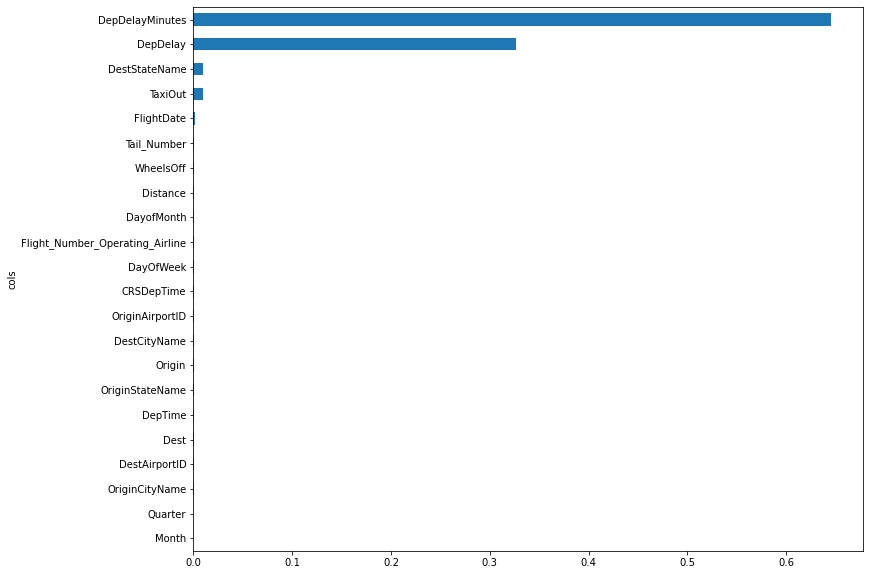

In [172]:
# Using graph to visualize feature importance
barh = feat_importance[:30].plot('cols', 'imp', 'barh', figsize = (12,10), legend = False)
barh = barh.invert_yaxis()
barh

**Based on the above results, we can see that "Quarter" and "Month" have no impact (value = 0) and conversely,
"DepDelayMinutes" has a huge impact on the model. Outside of the feature importance, we can see that it logically hints and directly provides arithmetic data to the model.Therefore, we are dropping those 3 columns to begin working on parameters optimization.**

In [60]:
Df.drop("Quarter", inplace = True, axis = 1)
Df.drop("Month", inplace = True, axis = 1)
Df.drop("DepDelayMinutes", inplace = True, axis = 1)

In [61]:
X_train, X_valid = split_vals(Df, n_train)
y_train, y_valid = split_vals(y, n_train)

X_small, _ = split_vals(X_train, n_small)
y_small, _ = split_vals(y_train, n_small)

print('Number of small training data points: X = {}, y = {}'.format(X_small.shape, y_small.shape))
print('Number of full training data points: X = {}, y = {}'.format(X_train.shape, y_train.shape))
print('Number of validation data points: X = {}, y = {}'.format(X_valid.shape, y_valid.shape))

Number of small training data points: X = (35000, 19), y = (35000,)
Number of full training data points: X = (574265, 19), y = (574265,)
Number of validation data points: X = (143566, 19), y = (143566,)


In [62]:
# Running the subset model again, without the 3 columns we dropped just before.
model = RandomForestRegressor(
    n_estimators = 50,
    min_samples_split = 10,
    max_features = 0.5, # default = 'auto'/None
    n_jobs = -1, 
    random_state = 42,
    
    bootstrap = True,
    oob_score = True, # default = False, 
    max_samples = 0.75, # default = None,
)

%time model.fit(X_small, y_small)
print_score(model, X_small, y_small, X_valid, y_valid)

CPU times: total: 6.78 s
Wall time: 841 ms
RMSE on train set: 5.8200
RMSE on valid set: 14.4721
R^2 on train set: 0.9852
R^2 on valid set: 0.9483
R^2 on oob set: 0.9653


**The results still show a very strong performance with some overfitting. We'll drop "DepDelay" as it showed a large feature importance as well.**

In [63]:
Df.drop("DepDelay", inplace = True, axis =1)

In [64]:
X_train, X_valid = split_vals(Df, n_train)
y_train, y_valid = split_vals(y, n_train)

X_small, _ = split_vals(X_train, n_small)
y_small, _ = split_vals(y_train, n_small)

print('Number of small training data points: X = {}, y = {}'.format(X_small.shape, y_small.shape))
print('Number of full training data points: X = {}, y = {}'.format(X_train.shape, y_train.shape))
print('Number of validation data points: X = {}, y = {}'.format(X_valid.shape, y_valid.shape))

Number of small training data points: X = (35000, 18), y = (35000,)
Number of full training data points: X = (574265, 18), y = (574265,)
Number of validation data points: X = (143566, 18), y = (143566,)


In [65]:
model = RandomForestRegressor(
    n_estimators = 50,
    min_samples_split = 10,
    max_features = 0.5, # default = 'auto'/None
    n_jobs = -1, 
    random_state = 42,
    
    bootstrap = True,
    oob_score = True, # default = False, 
    max_samples = 0.75, # default = None,
)

%time model.fit(X_small, y_small)
print_score(model, X_small, y_small, X_valid, y_valid)

CPU times: total: 7.2 s
Wall time: 887 ms
RMSE on train set: 27.0119
RMSE on valid set: 48.3274
R^2 on train set: 0.6821
R^2 on valid set: 0.4237
R^2 on oob set: 0.3688


### Parameter Optimization on Small Set
As the model has now come down to the baseline. And we can begin with optimizing strategies

In [66]:
model = RandomForestRegressor(
    n_estimators = 100,
    min_samples_split = 10,
    max_features = 0.5, # default = 'auto'/None
    n_jobs = -1, 
    random_state = 42,
    
    bootstrap = True,
    oob_score = True, # default = False, 
    max_samples = 0.75, # default = None,
)

%time model.fit(X_small, y_small)
print_score(model, X_small, y_small, X_valid, y_valid)

CPU times: total: 13.9 s
Wall time: 1.5 s
RMSE on train set: 26.8509
RMSE on valid set: 48.4455
R^2 on train set: 0.6859
R^2 on valid set: 0.4209
R^2 on oob set: 0.3848


In [67]:
model = RandomForestRegressor(
    n_estimators = 70,
    min_samples_split = 30,
    max_features = 0.5, # default = 'auto'/None
    n_jobs = -1, 
    random_state = 42,
    
    bootstrap = True,
    oob_score = True, # default = False, 
    max_samples = 0.75, # default = None,
)

%time model.fit(X_small, y_small)
print_score(model, X_small, y_small, X_valid, y_valid)

CPU times: total: 9.83 s
Wall time: 1.13 s
RMSE on train set: 33.1303
RMSE on valid set: 50.6619
R^2 on train set: 0.5218
R^2 on valid set: 0.3667
R^2 on oob set: 0.3423


In [83]:
model = RandomForestRegressor(
    n_estimators = 100,
    min_samples_split = 10,
    max_features = 0.75, # default = 'auto'/None
    n_jobs = -1, 
    random_state = 10,
    
    bootstrap = True,
    oob_score = True, # default = False, 
    max_samples = 0.80, # default = None,
)

%time model.fit(X_small, y_small)
print_score(model, X_small, y_small, X_valid, y_valid)

CPU times: user 31.1 s, sys: 86.6 ms, total: 31.2 s
Wall time: 4.65 s
RMSE on train set: 24.6753
RMSE on valid set: 43.6602
R^2 on train set: 0.7348
R^2 on valid set: 0.5296
R^2 on oob set: 0.4607


In [84]:
model = RandomForestRegressor(
    n_estimators = 50,
    min_samples_split = 10,
    max_features = 0.75, # default = 'auto'/None
    n_jobs = -1, 
    random_state = 10,
    
    bootstrap = True,
    oob_score = True, # default = False, 
    max_samples = 0.80, # default = None,
)

%time model.fit(X_small, y_small)
print_score(model, X_small, y_small, X_valid, y_valid)

CPU times: user 14.8 s, sys: 39.6 ms, total: 14.8 s
Wall time: 2.22 s
RMSE on train set: 24.6651
RMSE on valid set: 44.4145
R^2 on train set: 0.7350
R^2 on valid set: 0.5132
R^2 on oob set: 0.4400


In [85]:
model = RandomForestRegressor(
    n_estimators = 400,
    min_samples_split = 10,
    max_features = 0.75, # default = 'auto'/None
    n_jobs = -1, 
    random_state = 10,
    
    bootstrap = True,
    oob_score = True, # default = False, 
    max_samples = 0.80, # default = None,
)

%time model.fit(X_small, y_small)
print_score(model, X_small, y_small, X_valid, y_valid)

CPU times: user 2min 5s, sys: 424 ms, total: 2min 5s
Wall time: 18.6 s
RMSE on train set: 24.2600
RMSE on valid set: 43.2300
R^2 on train set: 0.7436
R^2 on valid set: 0.5389
R^2 on oob set: 0.4659


In [86]:
model = RandomForestRegressor(
    n_estimators = 400,
    min_samples_split = 10,
    max_features = 0.75, # default = 'auto'/None
    n_jobs = -1, 
    random_state = 42,
    
    bootstrap = True,
    oob_score = True, # default = False, 
    max_samples = 0.80, # default = None,
)

%time model.fit(X_small, y_small)
print_score(model, X_small, y_small, X_valid, y_valid)

CPU times: user 2min 10s, sys: 458 ms, total: 2min 10s
Wall time: 19.8 s
RMSE on train set: 24.5808
RMSE on valid set: 43.9916
R^2 on train set: 0.7368
R^2 on valid set: 0.5225
R^2 on oob set: 0.4548


In [87]:
model = RandomForestRegressor(
    n_estimators = 400,
    min_samples_split = 10,
    max_features = 0.75, # default = 'auto'/None
    n_jobs = -1, 
    random_state = 5,
    
    bootstrap = True,
    oob_score = True, # default = False, 
    max_samples = 0.80, # default = None,
)

%time model.fit(X_small, y_small)
print_score(model, X_small, y_small, X_valid, y_valid)

CPU times: user 2min 9s, sys: 600 ms, total: 2min 9s
Wall time: 21 s
RMSE on train set: 24.5650
RMSE on valid set: 44.0336
R^2 on train set: 0.7371
R^2 on valid set: 0.5216
R^2 on oob set: 0.4487


In [88]:
model = RandomForestRegressor(
    n_estimators = 400,
    min_samples_split = 10,
    max_features = 0.75, # default = 'auto'/None
    n_jobs = -1, 
    random_state = 20,
    
    bootstrap = True,
    oob_score = True, # default = False, 
    max_samples = 0.80, # default = None,
)

%time model.fit(X_small, y_small)
print_score(model, X_small, y_small, X_valid, y_valid)

CPU times: user 2min 3s, sys: 299 ms, total: 2min 4s
Wall time: 17.4 s
RMSE on train set: 24.5946
RMSE on valid set: 44.1178
R^2 on train set: 0.7365
R^2 on valid set: 0.5197
R^2 on oob set: 0.4538


In [89]:
model = RandomForestRegressor(
    n_estimators = 100,
    min_samples_split = 10,
    max_features = 0.75, # default = 'auto'/None
    n_jobs = -1, 
    random_state = 20,
    
    bootstrap = True,
    oob_score = True, # default = False, 
    max_samples = 0.80, # default = None,
)

%time model.fit(X_small, y_small)
print_score(model, X_small, y_small, X_valid, y_valid)

CPU times: user 30.3 s, sys: 126 ms, total: 30.4 s
Wall time: 5.03 s
RMSE on train set: 24.3876
RMSE on valid set: 43.6325
R^2 on train set: 0.7409
R^2 on valid set: 0.5302
R^2 on oob set: 0.4510


In [90]:
model = RandomForestRegressor(
    n_estimators = 400,
    min_samples_split = 2,
    max_features = 0.75, # default = 'auto'/None
    max_depth = 50,
    n_jobs = -1, 
    random_state = 15,
    
    bootstrap = True,
    oob_score = True, # default = False, 
    max_samples = 0.80, # default = None,
)

%time model.fit(X_small, y_small)
print_score(model, X_small, y_small, X_valid, y_valid)

CPU times: user 2min 13s, sys: 454 ms, total: 2min 13s
Wall time: 19.2 s
RMSE on train set: 15.9630
RMSE on valid set: 43.9444
R^2 on train set: 0.8890
R^2 on valid set: 0.5235
R^2 on oob set: 0.4607


In [91]:
model = RandomForestRegressor(
    n_estimators = 400,
    min_samples_split = 2,
    max_features = 0.75, # default = 'auto'/None
    max_depth = None,
    n_jobs = -1, 
    random_state = 15,
    
    bootstrap = True,
    oob_score = True, # default = False, 
    max_samples = 0.80, # default = None,
)

%time model.fit(X_small, y_small)
print_score(model, X_small, y_small, X_valid, y_valid)

CPU times: user 2min 13s, sys: 593 ms, total: 2min 13s
Wall time: 20.5 s
RMSE on train set: 15.9610
RMSE on valid set: 43.9347
R^2 on train set: 0.8890
R^2 on valid set: 0.5237
R^2 on oob set: 0.4608


In [92]:
model = RandomForestRegressor(
    n_estimators = 400,
    min_samples_split = 5,
    max_features = 0.75, # default = 'auto'/None
    max_depth = 50,
    n_jobs = -1, 
    random_state = 15,
    
    bootstrap = True,
    oob_score = True, # default = False, 
    max_samples = 0.80, # default = None,
)

%time model.fit(X_small, y_small)
print_score(model, X_small, y_small, X_valid, y_valid)

CPU times: user 2min 7s, sys: 337 ms, total: 2min 8s
Wall time: 18.1 s
RMSE on train set: 20.3455
RMSE on valid set: 43.6581
R^2 on train set: 0.8197
R^2 on valid set: 0.5297
R^2 on oob set: 0.4633


In [68]:
model = RandomForestRegressor(
    n_estimators = 400,
    min_samples_split = 5,
    max_features = 0.75, # default = 'auto'/None
    max_depth = 50,
    n_jobs = -1, 
    random_state = 42,
    
    bootstrap = True,
    oob_score = True, # default = False, 
    max_samples = 0.80, # default = None,
)

%time model.fit(X_small, y_small)
print_score(model, X_small, y_small, X_valid, y_valid)

CPU times: total: 1min 40s
Wall time: 7.11 s
RMSE on train set: 20.4053
RMSE on valid set: 44.1615
R^2 on train set: 0.8186
R^2 on valid set: 0.5188
R^2 on oob set: 0.4580


### Fitting the model on complete Data Set

In [69]:
model = RandomForestRegressor(
    n_estimators = 400,
    min_samples_split = 5,
    max_features = 0.75, # default = 'auto'/None
    max_depth = 50,
    n_jobs = -1, 
    random_state = 15,
    
    bootstrap = True,
    oob_score = True, # default = False, 
    max_samples = 0.80, # default = None,
)

%time model.fit(X_train, y_train)
print_score(model, X_train, y_train, X_valid, y_valid)

CPU times: total: 41min 21s
Wall time: 2min 40s
RMSE on train set: 14.6638
RMSE on valid set: 27.0931
R^2 on train set: 0.9317
R^2 on valid set: 0.8189
R^2 on oob set: 0.7943


In [95]:
model = RandomForestRegressor(
    n_estimators = 400,
    min_samples_split = 5,
    max_features = 0.8, # default = 'auto'/None
    max_depth = 50,
    n_jobs = -1, 
    random_state = 15,
    
    bootstrap = True,
    oob_score = True, # default = False, 
    max_samples = 0.80, # default = None,
)

%time model.fit(X_train, y_train)
print_score(model, X_train, y_train, X_valid, y_valid)

CPU times: user 47min 46s, sys: 10.9 s, total: 47min 56s
Wall time: 6min 39s
RMSE on train set: 14.5823
RMSE on valid set: 27.1174
R^2 on train set: 0.9325
R^2 on valid set: 0.8186
R^2 on oob set: 0.7947


In [104]:
model = RandomForestRegressor(
    n_estimators = 200,
    min_samples_split = 8,
    max_features = 0.8, # default = 'auto'/None
    max_depth = 50,
    n_jobs = -1, 
    random_state = 15,
    
    bootstrap = True,
    oob_score = True, # default = False, 
    max_samples = 0.80, # default = None,
)

%time model.fit(X_train, y_train)
print_score(model, X_train, y_train, X_valid, y_valid)

CPU times: user 23min 26s, sys: 4.52 s, total: 23min 30s
Wall time: 3min 15s
RMSE on train set: 16.2924
RMSE on valid set: 27.0896
R^2 on train set: 0.9157
R^2 on valid set: 0.8189
R^2 on oob set: 0.7941


### Running Grid Search for Best Model

In [108]:
param_grid = {'n_estimators': [100,200],
    'min_samples_split': [5,8],
    'max_features': [0.8],
    'max_depth' : [50],
    'max_samples': [0.80]}

In [109]:
tuned_model = GridSearchCV(
    estimator = model, 
    param_grid = param_grid, 
    scoring = None, # uses estimator's default score method
    n_jobs = -1, 
    refit = True, # keep a fitted version of the overall best model
    cv = 5, 
    return_train_score = True,
    verbose = 2,)


In [110]:
tuned_model.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END max_depth=50, max_features=0.8, max_samples=0.8, min_samples_split=5, n_estimators=200; total time=22.8min
[CV] END max_depth=50, max_features=0.8, max_samples=0.8, min_samples_split=8, n_estimators=100; total time=11.3min
[CV] END max_depth=50, max_features=0.8, max_samples=0.8, min_samples_split=5, n_estimators=100; total time=12.0min
[CV] END max_depth=50, max_features=0.8, max_samples=0.8, min_samples_split=5, n_estimators=200; total time=22.0min
[CV] END max_depth=50, max_features=0.8, max_samples=0.8, min_samples_split=5, n_estimators=100; total time=12.0min
[CV] END max_depth=50, max_features=0.8, max_samples=0.8, min_samples_split=5, n_estimators=200; total time=22.0min


GridSearchCV(cv=5,
             estimator=RandomForestRegressor(max_depth=50, max_features=0.8,
                                             max_samples=0.8,
                                             min_samples_split=8,
                                             n_estimators=200, n_jobs=-1,
                                             oob_score=True, random_state=15),
             n_jobs=-1,
             param_grid={'max_depth': [50], 'max_features': [0.8],
                         'max_samples': [0.8], 'min_samples_split': [5, 8],
                         'n_estimators': [100, 200]},
             return_train_score=True, verbose=2)

[CV] END max_depth=50, max_features=0.8, max_samples=0.8, min_samples_split=5, n_estimators=200; total time=22.8min
[CV] END max_depth=50, max_features=0.8, max_samples=0.8, min_samples_split=8, n_estimators=200; total time=17.0min
[CV] END max_depth=50, max_features=0.8, max_samples=0.8, min_samples_split=5, n_estimators=100; total time=12.0min
[CV] END max_depth=50, max_features=0.8, max_samples=0.8, min_samples_split=8, n_estimators=100; total time=10.8min
[CV] END max_depth=50, max_features=0.8, max_samples=0.8, min_samples_split=8, n_estimators=200; total time=17.1min
[CV] END max_depth=50, max_features=0.8, max_samples=0.8, min_samples_split=5, n_estimators=100; total time=12.1min
[CV] END max_depth=50, max_features=0.8, max_samples=0.8, min_samples_split=8, n_estimators=100; total time=11.0min
[CV] END max_depth=50, max_features=0.8, max_samples=0.8, min_samples_split=8, n_estimators=200; total time=16.6min
[CV] END max_depth=50, max_features=0.8, max_samples=0.8, min_samples_sp

In [111]:
best_model = tuned_model.best_estimator_
best_model

RandomForestRegressor(max_depth=50, max_features=0.8, max_samples=0.8,
                      min_samples_split=8, n_estimators=200, n_jobs=-1,
                      oob_score=True, random_state=15)

### Final Random Forest Model Performance

In [112]:
print_score(best_model, X_small, y_small, X_valid, y_valid)

RMSE on train set: 15.2962
RMSE on valid set: 27.0896
R^2 on train set: 0.8981
R^2 on valid set: 0.8189
R^2 on oob set: 0.7941


### An Alternative look through CatBoost

In [74]:
model = CatBoostRegressor(
    n_estimators = 50, # iterations, n_estimators, num_boost_round, num_trees
    random_seed = 42,
    loss_function = 'RMSE',
    #allow_writing_files = False,
    logging_level = 'Silent',
)

model.fit(X_small, y_small, plot = False)
print_score(model, X_small, y_small, X_valid, y_valid)

RMSE on train set: 20.5657
RMSE on valid set: 37.1038
R^2 on train set: 0.8158
R^2 on valid set: 0.6603


In [76]:
model = CatBoostRegressor(
    n_estimators = 200, # iterations, n_estimators, num_boost_round, num_trees
    random_seed = 42,
    loss_function = 'RMSE',
    #allow_writing_files = False,
    logging_level = 'Silent',
)

model.fit(X_train, y_train, plot = False)
print_score(model, X_train, y_train, X_valid, y_valid)

RMSE on train set: 20.6748
RMSE on valid set: 27.8871
R^2 on train set: 0.8643
R^2 on valid set: 0.8081


In [79]:
model = CatBoostRegressor(
    n_estimators = 200, # iterations, n_estimators, num_boost_round, num_trees
    random_seed = 30,
    loss_function = 'RMSE',
    #allow_writing_files = False,
    logging_level = 'Silent',
)

model.fit(X_train, y_train, plot = False)
print_score(model, X_train, y_train, X_valid, y_valid)

RMSE on train set: 20.8251
RMSE on valid set: 27.6127
R^2 on train set: 0.8623
R^2 on valid set: 0.8119


In [80]:
model = CatBoostRegressor(
    n_estimators = 400, # iterations, n_estimators, num_boost_round, num_trees
    random_seed = 30,
    loss_function = 'RMSE',
    #allow_writing_files = False,
    logging_level = 'Silent',
)

model.fit(X_train, y_train, plot = False)
print_score(model, X_train, y_train, X_valid, y_valid)

RMSE on train set: 20.2753
RMSE on valid set: 27.3505
R^2 on train set: 0.8695
R^2 on valid set: 0.8154


In [82]:
model = CatBoostRegressor(
    n_estimators = 1000, # iterations, n_estimators, num_boost_round, num_trees
    random_seed = 30,
    loss_function = 'RMSE',
    #allow_writing_files = False,
    logging_level = 'Silent',
)

model.fit(X_train, y_train, plot = False)
print_score(model, X_train, y_train, X_valid, y_valid)

RMSE on train set: 19.0840
RMSE on valid set: 26.7073
R^2 on train set: 0.8844
R^2 on valid set: 0.8240


### Model Interpretations & Final Thoughts

From the exhaustive process of optimization the final model of the RandomForestRegressor performs considerably better in comparison to the initial model that we began with on the small sets.

The performance is as follows:
R^2 on train set: 0.8981
R^2 on valid set: 0.8189
R^2 on oob set: 0.7941

The CatBoostRegressor shows a small improvement on the RandomForestRegressor.

The performance is as follows:
R^2 on train set: 0.8844
R^2 on valid set: 0.8240

It is quite evident that both the models are capping out around the same performance point. One possible explanation fo this would be the limitation of data. This limitation was precisely created by removal of features that provided a very high corelation to the target column. The provision of this data certainly will provide a step towards improved model performance. The data set however still provides convincing information of categorical and numerical nature which allow for a consitant performance of around R^2: 0.82. Although its good, the models are slightly overfit with train scores ranging in the higher 80s compared to test set. 

Logically the model does sort of look into the details provided by location of operation, the weather condition from the date of delays and other on field errors that may have occured at airports on a given day.